<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas
data = pandas.read_csv('D:/Applied AI/Assignments/Assignment 6/preprocessed_data.csv',nrows=50000)
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
# write your code in following steps for task 1
# 1. Split your data.
# 2. Perform Bag of Words Vectorization of text data.
# 3. Perform tfidf vectorization of text data.
# 4. perform one-hot encoding of categorical features.
# 5. perform normalization of numerical features
# 6. For set 1 stack up all the features using hstack()
# 7. For set 2 stack up all the features using hstack()
# 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.
# 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
# 10. Plot confusion matrix based on the best threshold value
# 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.
# 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
# 13. You can use Prettytable or any other tabular format for comparison.


# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
Y= data['project_is_approved'].values
X= data.drop(['project_is_approved'],axis =1)

    

In [5]:
# Split the dataset 
# 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
# 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33, stratify=Y,random_state=42)


<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [6]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)
bow_vector = CountVectorizer(min_df=10,ngram_range=(1,4),max_features=50000)
bow_vector.fit(X_train['essay'].values)# fitting the essay 

X_train_bow_essay = bow_vector.transform(X_train['essay'].values) #transforming the essay of train
X_test_bow_essay = bow_vector.transform(X_test['essay'].values) # transforming the essay of test

print(X_train_bow_essay.shape,Y_train.shape)
print(X_test_bow_essay.shape,Y_test.shape)




(33500, 50000) (33500,)
(16500, 50000) (16500,)


In [7]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)
tfidf_vector = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=50000)
tfidf_vector.fit(X_train['essay'].values)

tfidf_x_train_essay = tfidf_vector.transform(X_train['essay'].values)#transform the essay using tfidf of train data
tfidf_x_test_essay = tfidf_vector.transform(X_test['essay'].values)# transform the essay using tfidf of test data

print(tfidf_x_train_essay.shape, Y_train.shape)
print(tfidf_x_test_essay.shape,Y_test.shape)


(33500, 50000) (33500,)
(16500, 50000) (16500,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [8]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# Apply Normalization on the numerical features using Normalizer().
vector_school_state = CountVectorizer()
vector_school_state.fit(X_train['school_state'].values)
onehot_school_state_train = vector_school_state.transform(X_train['school_state'].values)
onehot_school_state_test = vector_school_state.transform(X_test['school_state'].values)
print(onehot_school_state_train.shape,Y_train.shape)
print(onehot_school_state_test.shape,Y_test.shape)

(33500, 51) (33500,)
(16500, 51) (16500,)


In [9]:
#one-hot encoding of teacher_prefix
vector_teacher_prefix = CountVectorizer()
vector_teacher_prefix.fit(X_train['teacher_prefix'].values)
vector_teacher_prefix_train= vector_teacher_prefix.transform(X_train['teacher_prefix'].values)
vector_teacher_prefix_test=vector_teacher_prefix.transform(X_test['teacher_prefix'].values)
print(vector_teacher_prefix_train.shape,Y_train.shape )
print(vector_teacher_prefix_test.shape,Y_test.shape)

(33500, 5) (33500,)
(16500, 5) (16500,)


In [10]:
#one-hot encoding of project_grade_category
vector_project_grade_category=CountVectorizer()
vector_project_grade_category.fit(X_train['project_grade_category'].values)
vector_project_grade_category_train = vector_project_grade_category.transform(X_train['project_grade_category'].values)
vector_project_grade_category_test = vector_project_grade_category.transform(X_test['project_grade_category'].values)

print(vector_project_grade_category_train.shape,Y_train.shape)
print(vector_project_grade_category_test.shape,Y_test.shape)

(33500, 4) (33500,)
(16500, 4) (16500,)


In [11]:
#one-hot encoding of clean_categories
vector_clean_categories = CountVectorizer()
vector_clean_categories.fit(X_train['clean_categories'].values)
vector_clean_categories_train = vector_clean_categories.transform(X_train['clean_categories'].values)
vector_clean_categories_test = vector_clean_categories.transform(X_test['clean_categories'].values)
print(vector_clean_categories_train.shape,Y_train.shape)
print(vector_clean_categories_test.shape, Y_test.shape)

(33500, 9) (33500,)
(16500, 9) (16500,)


In [12]:
#one-hot encoding of clean_subcategories
vector_clean_subcategories = CountVectorizer()
vector_clean_subcategories.fit(X_train['clean_subcategories'].values)
vector_clean_subcategories_train=vector_clean_subcategories.transform(X_train['clean_subcategories'].values)
vector_clean_subcategories_test=vector_clean_subcategories.transform(X_test['clean_subcategories'].values)
print(vector_clean_subcategories_train.shape,Y_train.shape)
print(vector_clean_subcategories_test.shape,Y_test.shape)

(33500, 30) (33500,)
(16500, 30) (16500,)


In [13]:
#normalizing the price values and bringing into the same scale
normalizer = Normalizer()
X_train_price_norm =normalizer.fit_transform(X_train['price'].values.reshape(-1,1)) #fitting
X_test_price_norm = normalizer.fit_transform(X_test['price'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_price_norm.shape, Y_train.shape)
#print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, Y_test.shape)


After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


In [14]:
normalizer = Normalizer()
X_train_submission = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_submission = normalizer.fit_transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After Vectorizations")
print(X_train_submission.shape,Y_train.shape)
print(X_test_submission.shape,Y_test.shape)

After Vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


In [15]:
#Concatenating all the results
#Set 1: categorical, numerical features + preprocessed_eassay (BOW)
from scipy.sparse import hstack

X_train_set = hstack((onehot_school_state_train,vector_teacher_prefix_train,vector_project_grade_category_train,vector_clean_categories_train,vector_clean_subcategories_train,X_train_price_norm,X_train_submission,X_train_bow_essay)).tocsr()
X_test_set=hstack((onehot_school_state_test,vector_teacher_prefix_test,vector_project_grade_category_test,vector_clean_categories_test,vector_clean_subcategories_test,X_test_price_norm,X_test_submission,X_test_bow_essay)).tocsr()


In [16]:
print(X_train_set.shape)
print(X_test_set.shape)

(33500, 50101)
(16500, 50101)


In [17]:
#Concatenating all the results
#Set 2: categorical, numerical features + preprocessed_eassay (TF-IDF)
from scipy.sparse import hstack

X_train_set_2 = hstack((onehot_school_state_train,vector_teacher_prefix_train,vector_project_grade_category_train,vector_clean_categories_train,vector_clean_subcategories_train,X_train_price_norm,X_train_submission,tfidf_x_train_essay)).tocsr()
X_test_set_2=hstack((onehot_school_state_test,vector_teacher_prefix_test,vector_project_grade_category_test,vector_clean_categories_test,vector_clean_subcategories_test,X_test_price_norm,X_test_submission,tfidf_x_test_essay)).tocsr()


In [18]:
print(X_train_set_2.shape)
print(X_test_set_2.shape)

(33500, 50101)
(16500, 50101)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

#### Set 1

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

model=MultinomialNB(class_prior=[0.5,0.5])
param={'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
clf=GridSearchCV(model,param,scoring='roc_auc',cv=10,return_train_score=True) # running 10 fold cross validation grid search
clf.fit(X_train_set,Y_train) #fitting
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



In [20]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.
print('Best score: ',clf.best_score_)
print('alpha value with best score: ',clf.best_params_)
print('='*40)

Best score:  0.690591314241362
alpha value with best score:  {'alpha': 1}


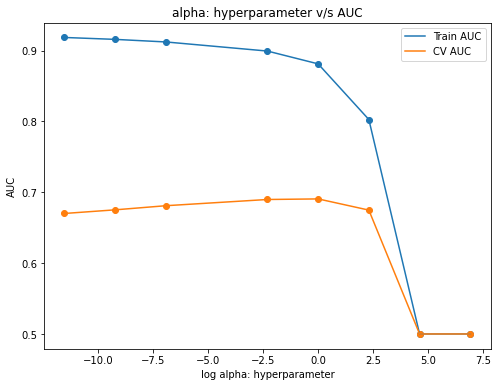

In [21]:
import math
log_param=[]
for i in param['alpha']:  # converting alpha into log- alpha
    log_param.append(math.log(i))
    
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(log_param, train_auc, label='Train AUC')
plt.plot(log_param, cv_auc, label='CV AUC')  
plt.scatter(log_param,train_auc)
plt.scatter(log_param,cv_auc)
plt.legend()
plt.xlabel("log alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)


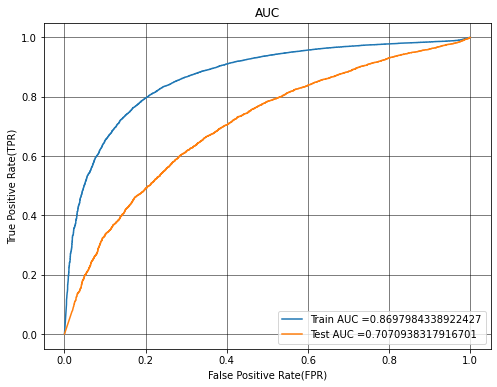

In [22]:
model_set1=MultinomialNB(alpha=1,class_prior=[0.5,0.5])
model_set1.fit(X_train_set,Y_train)
y_train_probs = clf.predict_proba(X_train_set)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_test_set )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_probs)

plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black',lw=0.5)

In [24]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.6375232714192042 for threshold 0.554
CONFUSION MATRIX OF TRAIN DATA


[[ 4306  1059]
 [ 5787 22348]]


<AxesSubplot:>

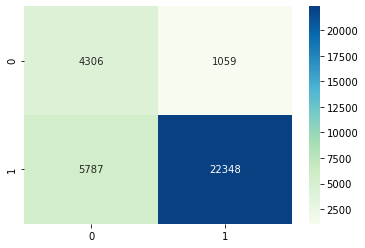

In [25]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(Y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu')

the maximum value of tpr*(1-fpr) 0.4333685595947826 for threshold 0.966
CONFUSION MATRIX OF TEST DATA


[[1732  910]
 [4697 9161]]


<AxesSubplot:>

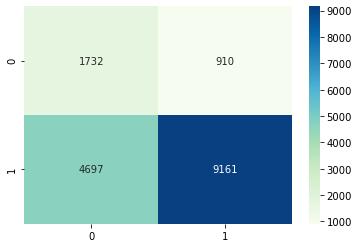

In [26]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(Y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu')

#### Set 2

In [27]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

model=MultinomialNB(class_prior=[0.5,0.5])
param={'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
clf=GridSearchCV(model,param,scoring='roc_auc',cv=10,return_train_score=True) # running 10 fold cross validation grid search
clf.fit(X_train_set_2,Y_train) #fitting
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [28]:
print('Best score: ',clf.best_score_)
print('alpha value with best score: ',clf.best_params_)
print('='*40)

Best score:  0.6746660335345722
alpha value with best score:  {'alpha': 0.1}


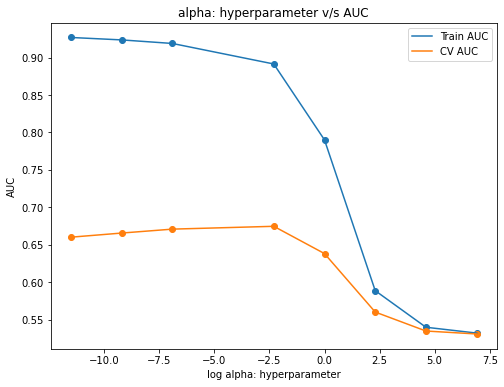

In [30]:
import math
log_param=[]
for i in param['alpha']:  # converting alpha into log- alpha
    log_param.append(math.log(i))
    
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(log_param, train_auc, label='Train AUC')
plt.plot(log_param, cv_auc, label='CV AUC')  
plt.scatter(log_param,train_auc)
plt.scatter(log_param,cv_auc)
plt.legend()
plt.xlabel("log alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)


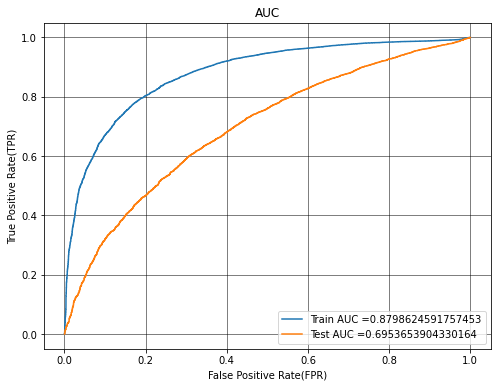

In [31]:
model_set2=MultinomialNB(alpha=1e-05,class_prior=[0.5,0.5])
model_set2.fit(X_train_set_2,Y_train)
y_train_probs = clf.predict_proba(X_train_set_2)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_test_set_2 )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_probs)

plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black',lw=0.5)

Train Data


Confusion Matrix

the maximum value of tpr*(1-fpr) 0.6452145866413284 for threshold 0.503
CONFUSION MATRIX OF TRAIN DATA


[[ 4356  1009]
 [ 5777 22358]]


<AxesSubplot:>

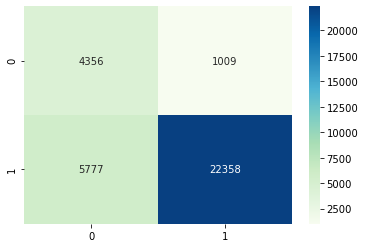

In [32]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(Y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu')

Test Data

the maximum value of tpr*(1-fpr) 0.4169003460971994 for threshold 0.594
CONFUSION MATRIX OF TEST DATA


[[1784  858]
 [5302 8556]]


<AxesSubplot:>

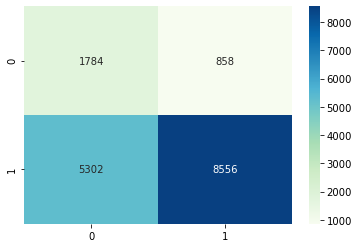

In [33]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(Y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu')

Top 20 features from set-1

In [34]:
from scipy.sparse import hstack
X_train_set = hstack((onehot_school_state_train,vector_teacher_prefix_train,vector_project_grade_category_train,vector_clean_categories_train,vector_clean_subcategories_train,X_train_price_norm,X_train_submission,X_train_bow_essay)).tocsr()
X_test_set=hstack((onehot_school_state_test,vector_teacher_prefix_test,vector_project_grade_category_test,vector_clean_categories_test,vector_clean_subcategories_test,X_test_price_norm,X_test_submission,X_test_bow_essay)).tocsr()


In [35]:
features=[]
for fe in bow_vector.get_feature_names() :
    features.append(fe)
    
for fe in vector_school_state.get_feature_names() :
    features.append(fe)
    
for fe in vector_teacher_prefix.get_feature_names() :  # adding all features into list as the order of data frame
    features.append(fe)
    
for fe in vector_project_grade_category.get_feature_names() :
    features.append(fe)
    
features.append("price")

for fe in vector_clean_categories.get_feature_names() :
    features.append(fe)
    
for fe in vector_clean_subcategories.get_feature_names() :
    features.append(fe)
    
features.append("teacher_number_of_previously_posted_projects")

In [36]:
class_0=model_set1.feature_log_prob_[0, :].argsort()   # finding probability and making argsort for each class
class_1=model_set1.feature_log_prob_[1, :].argsort()  

In [37]:
print("top 20 features of class_0")
print("="*80)
print(np.take(features, class_0[-20:])) # since argsort is asscending order

top 20 features of class_0
['able let' 'year math' 'come life' 'work hard every' 'we going'
 'need get wiggles' 'need area' 'many faced' '17 students'
 'my students could' 'the community' 'they come different backgrounds'
 'help focus' 'learn each' 'not conducive' 'classroom creating'
 'my goal classroom' 'learning daily basis' 'school brooklyn'
 'students able use']


In [38]:
print("top 20 features of class_1")
print("="*80)
print(np.take(features, class_1[-20:]))

top 20 features of class_1
['day instead' 'use home' 'need get wiggles' 'we going'
 'reading level students' 'work hard every' 'need area' 'many faced'
 '17 students' 'help focus' 'my students could' 'learn each'
 'they come different backgrounds' 'not conducive' 'the community'
 'learning daily basis' 'classroom creating' 'my goal classroom'
 'school brooklyn' 'students able use']


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

Note: you may need to restart the kernel to use updated packages.


'C:\Users\Vaddiraju' is not recognized as an internal or external command,
operable program or batch file.


In [43]:
from prettytable import PrettyTable
table=PrettyTable()
table.field_names = ["Vectorizer", "Model", "Hyper Parameter", "Test-AUC"] # # http://zetcode.com/python/prettytable/
table.add_row(["BOW", "Naive Bayes", 1, 0.69])
table.add_row(["TFIDF", "Naive Bayes", 0.1, 0.67])
print(table)

+------------+-------------+-----------------+----------+
| Vectorizer |    Model    | Hyper Parameter | Test-AUC |
+------------+-------------+-----------------+----------+
|    BOW     | Naive Bayes |        1        |   0.69   |
|   TFIDF    | Naive Bayes |       0.1       |   0.67   |
+------------+-------------+-----------------+----------+
